# MobileNet transfer learning

Pilot dataset mobile using transfer learning from the mobilenet architecture

## Config

In [1]:
import tensorflow as tf
from tensorflow.keras import Model, Sequential
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.applications import MobileNetV3Small, MobileNetV3Large
from tensorflow.keras.layers import RandomRotation, RandomFlip, RandomZoom, Dropout, Dense, Input
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.losses import BinaryCrossentropy
import matplotlib.pyplot as plt
import os

os.environ['TF_FORCE_GPU_ALLOW_GROWTH'] = 'true'
plt.rcParams['axes.facecolor'] = 'white'
plt.rcParams['figure.facecolor'] = 'white'
plt.rcParams['font.size'] = 12

In [2]:
# NOTEBOOK PARAMETERS
dest_path = '../datasets/pilot_final'
dest_metadata = '../datasets/pilot_final/dataset_metadata.csv'

train_path = '../datasets/pilot_final/train'
val_path = '../datasets/pilot_final/val'

image_size = (224, 224)
batch_size = 16
dropout_rate = 0.2

epochs = {
    'top_layer': 500,
    'fine_tuning': 500
}

learning_rates = {
    'top_layer': 0.0001,
    'fine_tuning': 0.00001
}

In [3]:
input_shape = (*image_size, 3)

## Datasets

In [4]:
train_dataset = tf.keras.utils.image_dataset_from_directory(train_path,
                                                            shuffle=True,
                                                            batch_size=batch_size,
                                                            image_size=image_size)

val_dataset = tf.keras.utils.image_dataset_from_directory(val_path,
                                                          shuffle=True,
                                                          batch_size=batch_size,
                                                          image_size=image_size)

Found 124 files belonging to 2 classes.
Found 32 files belonging to 2 classes.


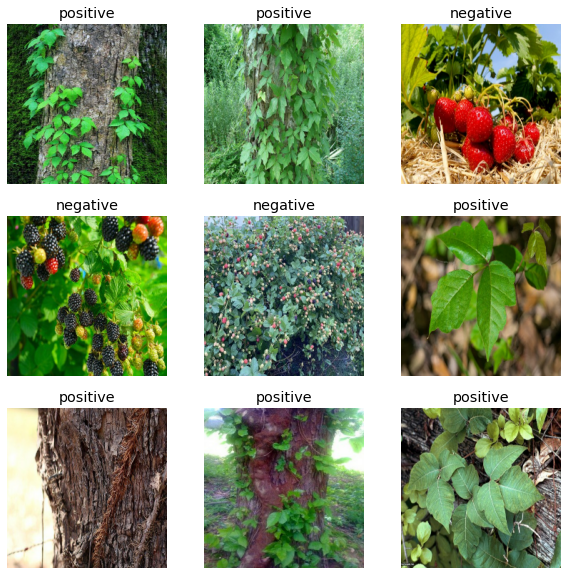

In [5]:
class_names = train_dataset.class_names

plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(images[i].numpy().astype("uint8"))
    plt.title(class_names[labels[i]])
    plt.axis("off")

## Processing layers

In [6]:
AUTOTUNE = tf.data.AUTOTUNE

train_dataset = train_dataset.prefetch(buffer_size=AUTOTUNE)
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)

### Image augmentation

In [7]:
image_aug = Sequential([
    RandomFlip('horizontal'),
    RandomRotation(0.2),
    RandomZoom(0.1)
])

### Mobilenet

In [8]:
mobilenet_small = MobileNetV3Small(input_shape=input_shape,
                             include_top=False,
                             weights='imagenet',
                             pooling='avg',
                             include_preprocessing=True,
                             dropout_rate=dropout_rate)

mobilenet_small.trainable = False
mobilenet_small.summary()

Model: "MobilenetV3small"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling (Rescaling)           (None, 224, 224, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling[0][0]                  
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

In [9]:
mobilenet_large = MobileNetV3Large(input_shape=input_shape,
                                   include_top=False,
                                   weights='imagenet',
                                   pooling='avg',
                                   include_preprocessing=True,
                                   dropout_rate=dropout_rate)

mobilenet_large.trainable = False
mobilenet_large.summary()

Model: "MobilenetV3large"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_2 (InputLayer)            [(None, 224, 224, 3) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 224, 224, 3)  0           input_2[0][0]                    
__________________________________________________________________________________________________
Conv (Conv2D)                   (None, 112, 112, 16) 432         rescaling_1[0][0]                
__________________________________________________________________________________________________
Conv/BatchNorm (BatchNormalizat (None, 112, 112, 16) 64          Conv[0][0]                       
___________________________________________________________________________________

## Create Models

In [10]:
def build_model(mobilenet):
    inputs = Input(shape=input_shape)
    x = image_aug(inputs)
    x = mobilenet(x, training=False)
    x = Dense(512, activation='relu')(x)
    x = Dropout(0.2)(x)
    outputs = Dense(1)(x)
    
    return(Model(inputs, outputs))
    

In [11]:
model_small = build_model(mobilenet_small)
model_large = build_model(mobilenet_large)

In [12]:
model_small.compile(optimizer=Adam(learning_rate=learning_rates['top_layer']),
                    loss=BinaryCrossentropy(from_logits=True),
                    metrics=['accuracy'])
model_large.compile(optimizer=Adam(learning_rate=learning_rates['top_layer']),
                    loss=BinaryCrossentropy(from_logits=True),
                    metrics=['accuracy'])

In [13]:
model_small.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_3 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3small (Functional (None, 1024)              1529968   
_________________________________________________________________
dense (Dense)                (None, 512)               524800    
_________________________________________________________________
dropout (Dropout)            (None, 512)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 1)                 513       
Total params: 2,055,281
Trainable params: 525,313
Non-trainable params: 1,529,968
_____________________________________________

In [14]:
model_large.summary()

Model: "model_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
sequential (Sequential)      (None, 224, 224, 3)       0         
_________________________________________________________________
MobilenetV3large (Functional (None, 1280)              4226432   
_________________________________________________________________
dense_2 (Dense)              (None, 512)               655872    
_________________________________________________________________
dropout_1 (Dropout)          (None, 512)               0         
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 513       
Total params: 4,882,817
Trainable params: 656,385
Non-trainable params: 4,226,432
___________________________________________

## Fit Base Models

In [15]:
early_stopping = EarlyStopping(patience=10, restore_best_weights=False)
reduce_lr = ReduceLROnPlateau(patience=3, factor=1./3.)
callbacks = [early_stopping, reduce_lr]

In [16]:
history_small = model_small.fit(train_dataset,
                                validation_data=val_dataset,
                                epochs=epochs['top_layer'],
                                callbacks=callbacks)

Epoch 1/500
8/8 [==============================] - 11s 299ms/step - loss: 0.7048 - accuracy: 0.5403 - val_loss: 0.5110 - val_accuracy: 0.7812
Epoch 2/500
8/8 [==============================] - 1s 84ms/step - loss: 0.5511 - accuracy: 0.6613 - val_loss: 0.4289 - val_accuracy: 0.7812
Epoch 3/500
8/8 [==============================] - 1s 74ms/step - loss: 0.4697 - accuracy: 0.7581 - val_loss: 0.3911 - val_accuracy: 0.8125
Epoch 4/500
8/8 [==============================] - 1s 73ms/step - loss: 0.4230 - accuracy: 0.8065 - val_loss: 0.3774 - val_accuracy: 0.8438
Epoch 5/500
8/8 [==============================] - 1s 81ms/step - loss: 0.3778 - accuracy: 0.8387 - val_loss: 0.3742 - val_accuracy: 0.8438
Epoch 6/500
8/8 [==============================] - 1s 83ms/step - loss: 0.3507 - accuracy: 0.8387 - val_loss: 0.3694 - val_accuracy: 0.8438
Epoch 7/500
8/8 [==============================] - 1s 69ms/step - loss: 0.3015 - accuracy: 0.8871 - val_loss: 0.3632 - val_accuracy: 0.8438
Epoch 8/500
8/8 [=

In [17]:
history_large = model_large.fit(train_dataset,
                                validation_data=val_dataset,
                                epochs=epochs['top_layer'],
                                callbacks=callbacks)

Epoch 1/500
8/8 [==============================] - 7s 344ms/step - loss: 0.6190 - accuracy: 0.6694 - val_loss: 0.5638 - val_accuracy: 0.7500
Epoch 2/500
8/8 [==============================] - 1s 81ms/step - loss: 0.4770 - accuracy: 0.8065 - val_loss: 0.4831 - val_accuracy: 0.7812
Epoch 3/500
8/8 [==============================] - 1s 82ms/step - loss: 0.3725 - accuracy: 0.8145 - val_loss: 0.4529 - val_accuracy: 0.7812
Epoch 4/500
8/8 [==============================] - 1s 82ms/step - loss: 0.3340 - accuracy: 0.8226 - val_loss: 0.4451 - val_accuracy: 0.8125
Epoch 5/500
8/8 [==============================] - 1s 82ms/step - loss: 0.3064 - accuracy: 0.8710 - val_loss: 0.4583 - val_accuracy: 0.8438
Epoch 6/500
8/8 [==============================] - 1s 81ms/step - loss: 0.2750 - accuracy: 0.8710 - val_loss: 0.4542 - val_accuracy: 0.8438
Epoch 7/500
8/8 [==============================] - 1s 86ms/step - loss: 0.2409 - accuracy: 0.8710 - val_loss: 0.4353 - val_accuracy: 0.8125
Epoch 8/500
8/8 [==

In [27]:
history_small.history['accuracy']

[0.5403226017951965,
 0.6612903475761414,
 0.7580645084381104,
 0.8064516186714172,
 0.8387096524238586,
 0.8387096524238586,
 0.8870967626571655,
 0.8709677457809448,
 0.8951612710952759,
 0.8629032373428345,
 0.9274193644523621,
 0.9032257795333862,
 0.9032257795333862,
 0.9516128897666931,
 0.9032257795333862,
 0.9435483813285828,
 0.9193548560142517,
 0.9193548560142517,
 0.9354838728904724]

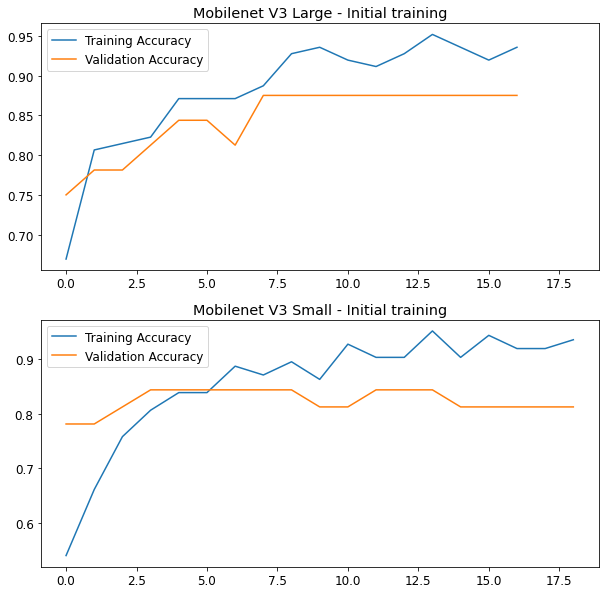

In [31]:
plt.figure(figsize=(10,10))

# Large model
ax = plt.subplot(2,1,1)
plt.plot(history_large.history['accuracy'], label='Training Accuracy')
plt.plot(history_large.history['val_accuracy'], label='Validation Accuracy')
plt.title("Mobilenet V3 Large - Initial training")
plt.legend()

# Small model
plt.subplot(2,1,2, sharex=ax)
plt.plot(history_small.history['accuracy'], label='Training Accuracy')
plt.plot(history_small.history['val_accuracy'], label='Validation Accuracy')
plt.title("Mobilenet V3 Small - Initial training")
plt.legend()

plt.show()

## Fine-tune models

## Analyze history

## Store models